In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import stats

import os
from tqdm import tqdm

%matplotlib inline

# 1D Data preparation

cpu


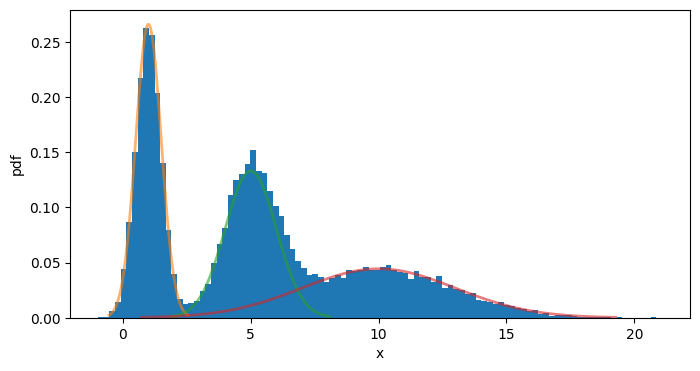

In [35]:
class MyDataset(Dataset):
    def __init__(self, means_list = [1, 5, 10], stds_list = [0.5, 1, 3], size = 10000, seed = 0):
        
        rvs_list = [stats.norm(loc=mean, scale=std) for mean, std in zip(means_list, stds_list)]

        np.random.seed(seed)
        x_train = np.concatenate([rvs.rvs(size) for rvs in rvs_list])
        
        #shuffle
        np.random.shuffle(x_train)

        self.x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
        self.x_numpy = x_train

        self.rvs_list = rvs_list
        self.n_rvs = len(rvs_list)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]
    
    def plot_data(self):
        fig,  ax =  plt.subplots( figsize = (8,4))
        ax.hist(self.x_numpy, bins = 100, density = True)

        for rvs in self.rvs_list:
            x = np.linspace(rvs.ppf(0.001), rvs.ppf(0.999), 100)
            ax.plot(x, rvs.pdf(x)/self.n_rvs, lw=2, alpha=0.6)
        ax.set_xlabel('x')
        ax.set_ylabel('pdf')
        plt.show()


BATCH_SIZE = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset = MyDataset(seed = 42)
test_dataset = MyDataset(seed = 43)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
train_dataset.plot_data()

In [37]:
# sanity check of batch size and shape
test_batch = next(iter(train_loader))
test_batch.shape

torch.Size([25, 1])

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim


        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2*latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )


